# EBA Pi

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../src/')
from vi_hrg import *
import pickle
torch.manual_seed(42)

In [2]:
# Load the data

df_pi = pd.read_csv('../data/EBA/EBA_Pi.csv')
df_theta = pd.read_csv('../data/EBA/EBA_Theta.csv')

In [3]:
df_theta.head()

bank_id                      asset      exposure
0   AT001  commercial.real.estate_AT  1.180243e+10
1   AT001  commercial.real.estate_CZ  2.387017e+09
2   AT001  commercial.real.estate_DE  4.177699e+08
3   AT001  commercial.real.estate_FR  2.320000e+06
4   AT001  commercial.real.estate_GB  1.380994e+07

In [4]:
nodes_pi = np.hstack((df_pi['bank_id'].unique(), df_pi['asset'].unique()))
nodes_theta = np.hstack((df_theta['bank_id'].unique(), df_theta['asset'].unique()))

In [5]:
A_theta = np.zeros((len(nodes_theta), len(nodes_theta)))
for i in np.array(df_theta):
    a = np.where(nodes_theta==i[0])[0].item()
    b = np.where(nodes_theta==i[1])[0].item()
    A_theta[a,b] = i[2]
A_theta += A_theta.T
A_theta = torch.FloatTensor(A_theta)
A_theta_edges = torch.where(A_theta>0, torch.ones(A_theta.size()), torch.zeros(A_theta.size())) 

In [6]:
A_pi = np.zeros((len(nodes_pi), len(nodes_pi)))
for i in np.array(df_pi):
    a = np.where(nodes_pi==i[0])[0].item()
    b = np.where(nodes_pi==i[1])[0].item()
    A_pi[a,b] = i[2]
A_pi += A_pi.T
A_pi = torch.FloatTensor(A_pi)
A_pi_edges = torch.where(A_pi>0, torch.ones(A_pi.size()), torch.zeros(A_pi.size())) 

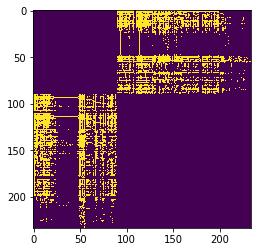

In [7]:
plt.imshow(A_pi_edges)
plt.show()

In [8]:
def cat_dict(lst_dict):
    keys = lst_dict[0].keys()
    n = len(lst_dict)
    out = {}
    for k in keys:
        l = []
        for i in range(n):
            l.append(lst_dict[i][k])
        if k!='state_dicts':
            out[k] = torch.cat(l, dim=0)
    return out   

In [9]:
def permute(tensor, perm=None):
    t = tensor + tensor.max()
    uni = t.unique().clone()
    if perm is None:
        perm = range(len(uni))
    for i in range(len(perm)):
        t = torch.where(t==uni[i], 
                            torch.ones(t.size())*perm[i],
                            t)
    return t

In [10]:
def n_est(A):
    n_total = A.shape[0]
    F1 = (A.sum(dim=0)==1).sum().item()
    F2 = (A.sum(dim=0)==2).sum().item()
    return n_total + max(0, 2*F1-F2)

def alpha_est(A):
    n = A.shape[0]
    x = A.sum(dim=0)/A.sum(dim=0).min()
    #log_x = A.sum(dim=0).log().clamp(min=0.)
    return n*(x.log()).sum().reciprocal()/2   

R_est = lambda A,a,T: 2*(8*n_est(A)**2*a**2*T/(A.sum()*torch.tensor(np.pi*T).sin()*(2*a-1)**2)).log()
r_i_est = lambda A, a, T, R: torch.clamp(2*torch.log(2*n_est(A)*a*T/(A.sum(axis=0)*torch.sin(np.pi*T)*(a-0.5))),
                                        max=R.item())

In [11]:
def grad_transform(grad):
    return 2*np.pi*grad/360

In [12]:
# Fixed parameters
alpha = torch.tensor(0.75)
T = torch.tensor(0.1)

In [13]:
print('Estimated R =', R_est(A_pi_edges,alpha,T).item())
print('Estimated alpha =', alpha_est(A_pi_edges).item())

Estimated R = 7.597213268280029
Estimated alpha = 0.16438663005828857


 /home/mo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor). 


In [14]:
data_folder = '../data/EBA/'
coord_file = 'EBA_Pi_orig-coordinates.txt'
links_file = 'EBA_Pi_orig-links.txt'
data_file = 'EBA_Pi.csv'
df_coord = pd.read_csv(data_folder+coord_file, sep='\t', header=None)
df_links = pd.read_csv(data_folder+links_file, sep='\t', header=None)
df_pi = pd.read_csv(data_folder+data_file)
col_coord = ['id', 'r', 'phi']
df_coord.columns=col_coord 
df_coord['phi'] = grad_transform(df_coord['phi'])

# Fit with fixed R

In [15]:
print('Maximal r_i in Potsdam fit = ', np.array(df_coord['r']).max())

Maximal r_i in Potsdam fit =  5.853335481486987


In [16]:
# Fix R
R = 5.854

In [17]:
N = len(A_pi_edges)
r_init = torch.tensor(df_coord['r'])
r_loc_init = logit(r_init/R)
r_scale_init = (torch.ones([N])/8).log()
phi_loc_init = polar2cart(1, torch.tensor(df_coord['phi']))
phi_scale_init = (torch.ones([N])*50).log()
R_conc_init = torch.tensor(60.).log()
R_scale_init = torch.tensor(.1).log()        
T_init = torch.tensor([3.,10.]).log()        

In [18]:
dataloader = DataLoader(EdgesDataset(A_pi_edges), batch_size=int(N*4), num_workers=0, shuffle=True)
vi = VI_HRG(N,20, init_values={'rs_loc':r_loc_init,
                               'rs_scale':r_scale_init,
                                'phis_loc':phi_loc_init,
                                'phis_scale':phi_scale_init, 
                                'R_conc':R_conc_init, 
                                'R_scale':R_scale_init,
                                'alpha_conc':None,
                                'alpha_scale':None,
                                'T':T_init},
                   fixed={'R':R, 
                          'T':0.1,
                          'alpha':0.75},
                   priors={'R_p':torch.tensor([20., 0.4]), 
                           'T_p':torch.tensor([3., 10.]),
                           'alpha_p':torch.tensor([27., 0.03])},)
A_lh_Potsdam = vi.get_A_lh(dataloader)

In [19]:
order = r_init.argsort()

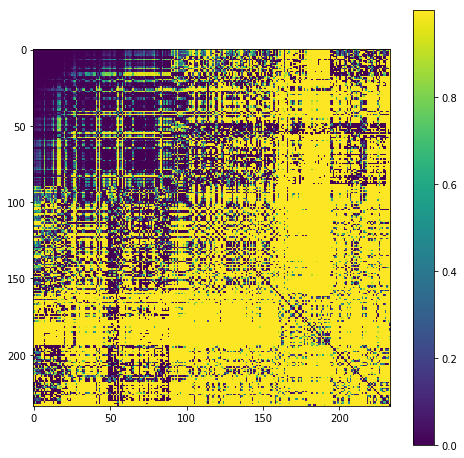

In [20]:
plt.figure(figsize=(8,8))
plt.imshow(A_lh_Potsdam.exp()[order,:][:,order])
plt.colorbar()
plt.show()

In [21]:
vi.train(dataloader, lrs=[0.1, 0.05, 0.01], debug=False, epochs=30)

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 123798.89 | Epoch time 3.12
Epoch 2 | LR: 0.10 | Total loss: 108028.58 | Epoch time 3.42
Epoch 3 | LR: 0.10 | Total loss: 102465.93 | Epoch time 3.39
Epoch 4 | LR: 0.10 | Total loss: 99079.92 | Epoch time 3.16
Epoch 5 | LR: 0.10 | Total loss: 96544.83 | Epoch time 2.85
Epoch 6 | LR: 0.10 | Total loss: 94722.26 | Epoch time 3.20
Epoch 7 | LR: 0.10 | Total loss: 93792.52 | Epoch time 3.70
Epoch 8 | LR: 0.10 | Total loss: 92647.60 | Epoch time 3.52
Epoch 9 | LR: 0.10 | Total loss: 91828.20 | Epoch time 3.28
Epoch 10 | LR: 0.10 | Total loss: 91190.09 | Epoch time 4.02
Epoch 11 | LR: 0.10 | Total loss: 90750.03 | Epoch time 3.88
Epoch 12 | LR: 0.10 | Total loss: 90096.57 | Epoch time 4.22
Epoch 13 | LR: 0.10 | Total loss: 89719.35 | Epoch time 4.02
Epoch 14 | LR: 0.10 | Total loss: 88989.30 | Epoch time 3.42
Epoch 15 | LR: 0.10 | Total loss: 88625.02 | Epoch time 3.60
Epoch 16 | LR: 0.10 | Total loss: 88331.72 | Epoch time 3.44

 ../src/utils.py:126: UserWarning:edes_prob_arg has NaN in it! 


Epoch 37 | LR: 0.05 | Total loss: 82483.16 | Epoch time 3.07
Epoch 38 | LR: 0.05 | Total loss: 82364.93 | Epoch time 3.04
Epoch 39 | LR: 0.05 | Total loss: 82314.32 | Epoch time 3.01
Epoch 40 | LR: 0.05 | Total loss: 82002.34 | Epoch time 3.01
Epoch 41 | LR: 0.05 | Total loss: 82144.09 | Epoch time 3.05
Epoch 42 | LR: 0.05 | Total loss: 81646.79 | Epoch time 3.07
Epoch 43 | LR: 0.05 | Total loss: 81338.87 | Epoch time 3.02
Epoch 44 | LR: 0.05 | Total loss: 81299.77 | Epoch time 3.05
Epoch 45 | LR: 0.05 | Total loss: 81362.31 | Epoch time 3.06
Epoch 46 | LR: 0.05 | Total loss: 81210.81 | Epoch time 3.01
Epoch 47 | LR: 0.05 | Total loss: 81207.32 | Epoch time 2.95
Epoch 48 | LR: 0.05 | Total loss: 80810.13 | Epoch time 3.08
Epoch 49 | LR: 0.05 | Total loss: 80739.76 | Epoch time 3.04
Epoch 50 | LR: 0.05 | Total loss: 80641.10 | Epoch time 3.02
Epoch 51 | LR: 0.05 | Total loss: 80637.29 | Epoch time 2.98
Epoch 52 | LR: 0.05 | Total loss: 80806.18 | Epoch time 3.14
Epoch 53 | LR: 0.05 | To

In [22]:
A_lh_fitted = vi.get_A_lh(dataloader)

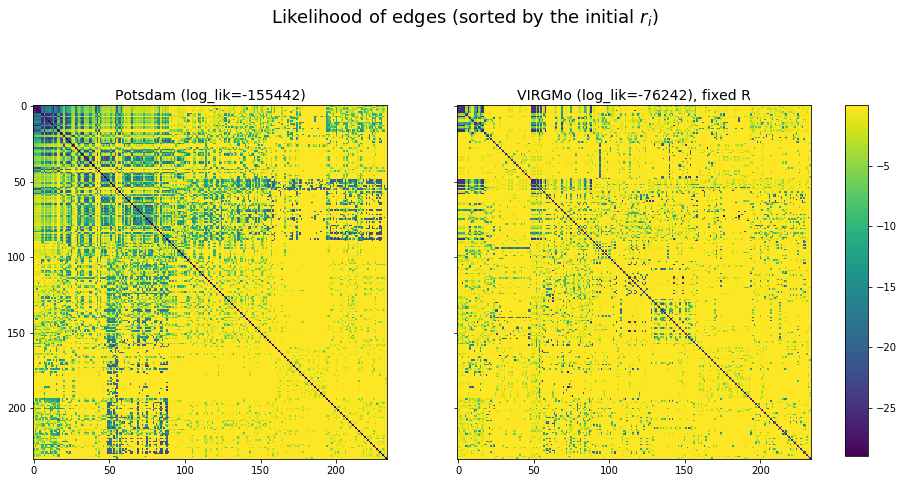

In [145]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
fig.suptitle(r'Likelihood of edges (sorted by the initial $r_i$)', size=18)
axs[0].set_title('Potsdam (log_lik=%.0f)' % A_lh_Potsdam.sum().item(), size=14)
axs[1].set_title('VIRGMo (log_lik=%.0f), fixed R' % A_lh_fitted.sum().item(), size=14)
axs[0].imshow(A_lh_Potsdam[order,:][:,order]) 
ax = axs[1].imshow(A_lh_fitted[order,:][:,order]) 
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.2, 0.02, 0.61])
fig.colorbar(ax, cax=cbar_ax, aspect=30)
#plt.savefig('Likelihood_Potsdam_vs_VIRGMo+fixR.png')
plt.show()

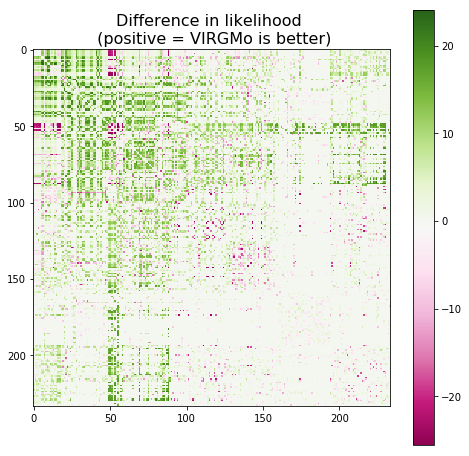

In [146]:
plt.figure(figsize=(8,8))
plt.title('Difference in likelihood \n (positive = VIRGMo is better)', size=16)
plt.imshow((A_lh_fitted - A_lh_Potsdam)[order,:][:,order], cmap='PiYG')
plt.colorbar()
plt.show()

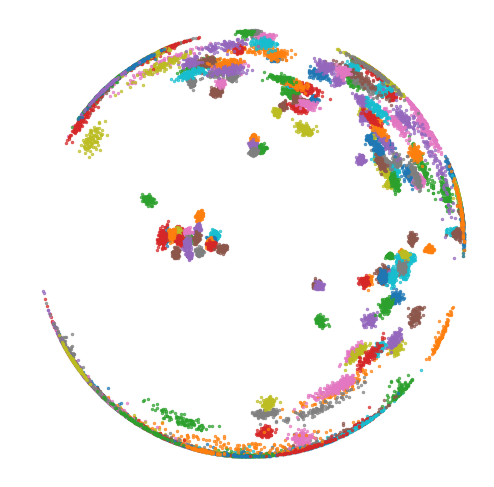

Likelihood: -76453.45408210745


In [29]:
nodes = vi.posterior_samples(100)
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='polar')
for i in range(N):
    ax.scatter(nodes[:,i,1].numpy(), nodes[:,i,0].numpy(), alpha=0.7, s=6)
#ax.scatter(theta.numpy(), r.numpy(), alpha=0.7, s=6, color='black')
#for link in A.nonzero():
#    ax.plot(theta[link].numpy(), r[link].numpy(), color='gray', alpha=0.2)
ax.set_rmax(R*1.02)
ax.set_rticks([]) 
ax.set_axis_off()
plt.show()
print('Likelihood:', vi.likelihood())

In [26]:
rs_, phis_, R_, T_, alpha_ = vi.qmean()

In [27]:
assets = df_pi['asset'].unique()
banks = df_pi['bank_id'].unique()
assets_num = np.array(df_coord[df_coord['id'].isin(assets)].index)
banks_num = np.array(df_coord[df_coord['id'].isin(banks)].index)

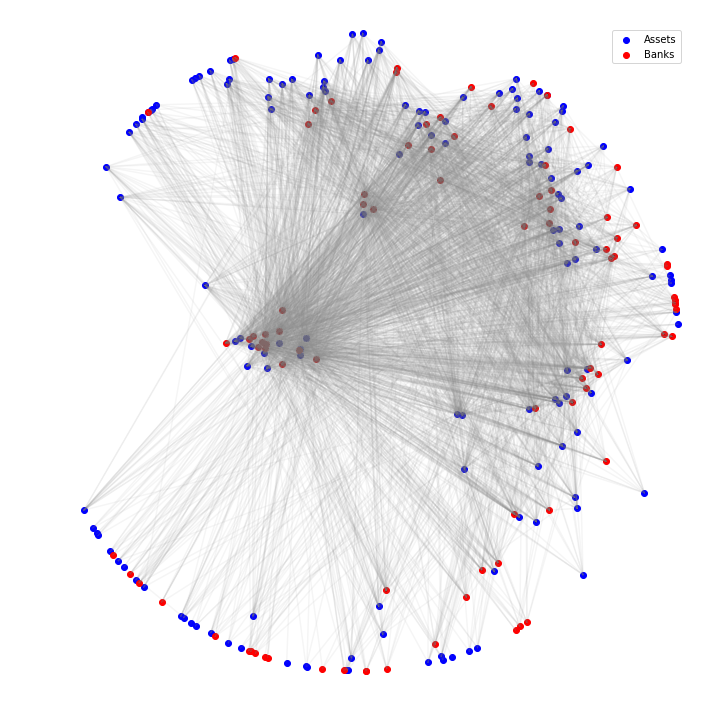

In [28]:
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111, projection='polar')
    
nodes_coord = np.array(df_coord)
for i in range(A_pi_edges.size()[0]):
    for j in range(A_pi_edges.size()[1]):
        if A_pi_edges[i,j]==1:
            ax.plot(c2d(phis_)[[i,j]], rs_[[i,j]], color='gray', alpha=0.04)
ax.scatter(c2d(phis_)[assets_num], rs_[assets_num], label='Assets', color='blue')
ax.scatter(c2d(phis_)[banks_num], rs_[banks_num], label='Banks', color='red')
        
ax.set_rmax(df_coord['r'].max()*1.02)
ax.set_rticks([]) 
ax.legend()
ax.set_axis_off()
plt.savefig('EBA_HRG_VIRGMo.png')
plt.show()   

# Fit with free R

In [30]:
dataloader = DataLoader(EdgesDataset(A_pi_edges), batch_size=int(N*4), num_workers=0, shuffle=True)
vi = VI_HRG(N,20, init_values={'rs_loc':r_loc_init,
                               'rs_scale':r_scale_init,
                                'phis_loc':phi_loc_init,
                                'phis_scale':phi_scale_init, 
                                'R_conc':R_conc_init, 
                                'R_scale':R_scale_init,
                                'alpha_conc':None,
                                'alpha_scale':None,
                                'T':T_init},
                   fixed={'R':None, 
                          'T':0.1,
                          'alpha':0.75},
                   priors={'R_p':torch.tensor([20., 0.4]), 
                           'T_p':torch.tensor([3., 10.]),
                           'alpha_p':torch.tensor([27., 0.03])},)

In [31]:
vi.train(dataloader, lrs=[0.1, 0.05, 0.01], debug=False, epochs=30)

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 50927.17 | Epoch time 3.34
Epoch 2 | LR: 0.10 | Total loss: 23853.37 | Epoch time 2.91
Epoch 3 | LR: 0.10 | Total loss: 23196.32 | Epoch time 3.04
Epoch 4 | LR: 0.10 | Total loss: 22921.29 | Epoch time 3.06
Epoch 5 | LR: 0.10 | Total loss: 22708.94 | Epoch time 3.26
Epoch 6 | LR: 0.10 | Total loss: 22458.94 | Epoch time 4.25
Epoch 7 | LR: 0.10 | Total loss: 22240.56 | Epoch time 3.04
Epoch 8 | LR: 0.10 | Total loss: 22031.85 | Epoch time 3.04
Epoch 9 | LR: 0.10 | Total loss: 21830.12 | Epoch time 3.46
Epoch 10 | LR: 0.10 | Total loss: 21617.91 | Epoch time 3.39
Epoch 11 | LR: 0.10 | Total loss: 21391.38 | Epoch time 3.04
Epoch 12 | LR: 0.10 | Total loss: 21168.24 | Epoch time 3.84
Epoch 13 | LR: 0.10 | Total loss: 21034.24 | Epoch time 4.16
Epoch 14 | LR: 0.10 | Total loss: 20864.29 | Epoch time 3.90
Epoch 15 | LR: 0.10 | Total loss: 20777.69 | Epoch time 3.57
Epoch 16 | LR: 0.10 | Total loss: 20666.18 | Epoch time 3.61
Ep

In [32]:
A_lh_fitted_freeR = vi.get_A_lh(dataloader)

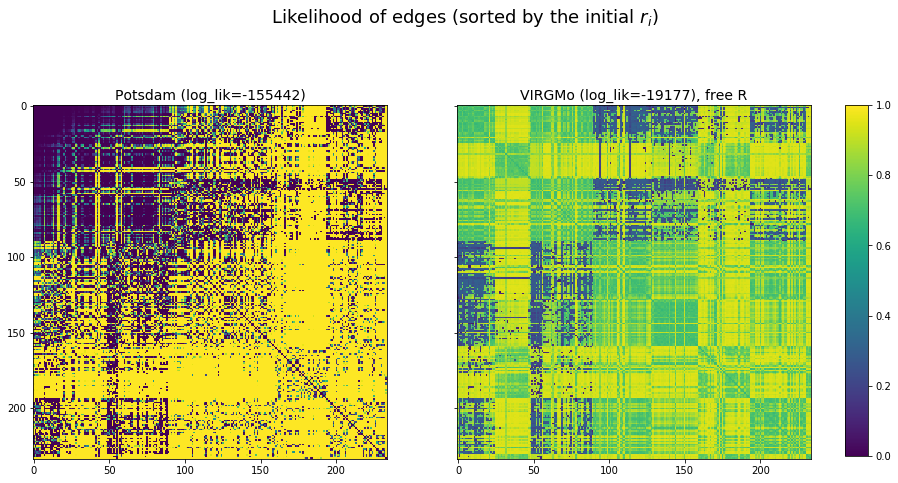

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
fig.suptitle(r'Likelihood of edges (sorted by the initial $r_i$)', size=18)
axs[0].set_title('Potsdam (log_lik=%.0f)' % A_lh_Potsdam.sum().item(), size=14)
axs[1].set_title('VIRGMo (log_lik=%.0f), free R' % A_lh_fitted_freeR.sum().item(), size=14)
axs[0].imshow(A_lh_Potsdam.exp()[order,:][:,order], vmin=0., vmax=1.) 
ax = axs[1].imshow(A_lh_fitted_freeR.exp()[order,:][:,order], vmin=0., vmax=1.) 
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.2, 0.02, 0.61])
fig.colorbar(ax, cax=cbar_ax, aspect=30)
plt.show()

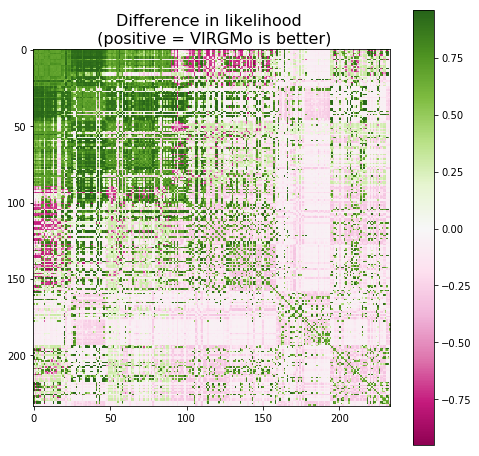

In [47]:
plt.figure(figsize=(8,8))
plt.title('Difference in likelihood \n (positive = VIRGMo is better)', size=16)
plt.imshow((A_lh_fitted_freeR.exp() - A_lh_Potsdam.exp())[order,:][:,order], cmap='PiYG')
plt.colorbar()
plt.show()

In [35]:
rs_, phis_, R_, T_, alpha_ = vi.qmean()

In [36]:
print('Fitted R = ', R_.item())

Fitted R =  0.538410910554348


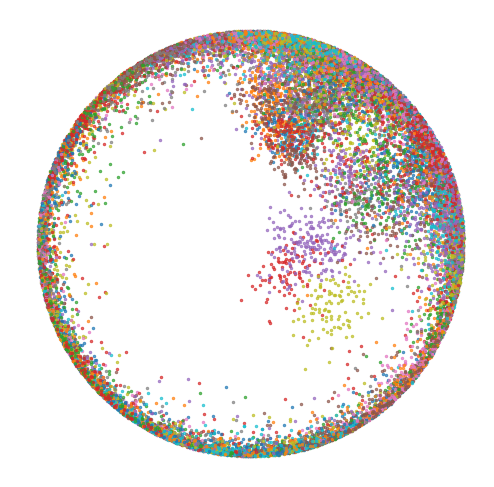

Likelihood: -19354.323006185623


In [37]:
nodes = vi.posterior_samples(100)
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='polar')
for i in range(N):
    ax.scatter(nodes[:,i,1].numpy(), nodes[:,i,0].numpy(), alpha=0.7, s=6)
#ax.scatter(theta.numpy(), r.numpy(), alpha=0.7, s=6, color='black')
#for link in A.nonzero():
#    ax.plot(theta[link].numpy(), r[link].numpy(), color='gray', alpha=0.2)
ax.set_rmax(R_.item()*1.02)
ax.set_rticks([]) 
ax.set_axis_off()
plt.show()
print('Likelihood:', vi.likelihood())

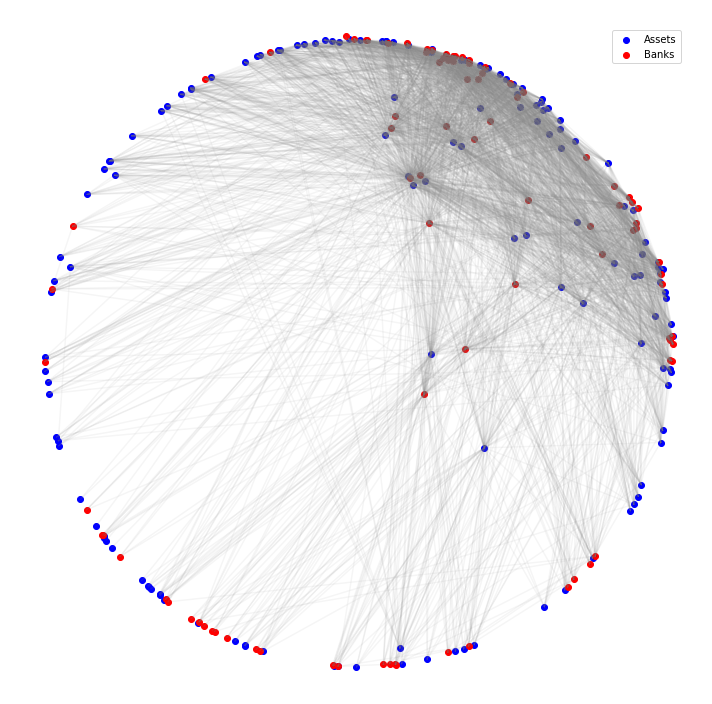

In [38]:
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111, projection='polar')
    
nodes_coord = np.array(df_coord)
for i in range(A_pi_edges.size()[0]):
    for j in range(A_pi_edges.size()[1]):
        if A_pi_edges[i,j]==1:
            ax.plot(c2d(phis_)[[i,j]], rs_[[i,j]], color='gray', alpha=0.04)
ax.scatter(c2d(phis_)[assets_num], rs_[assets_num], label='Assets', color='blue')
ax.scatter(c2d(phis_)[banks_num], rs_[banks_num], label='Banks', color='red')
        
ax.set_rmax(R_.item()*1.02)
ax.set_rticks([]) 
ax.legend()
ax.set_axis_off()
#plt.savefig('EBA_HRG_VIRGMo.png')
plt.show()   

# Comparison between fixed and free R

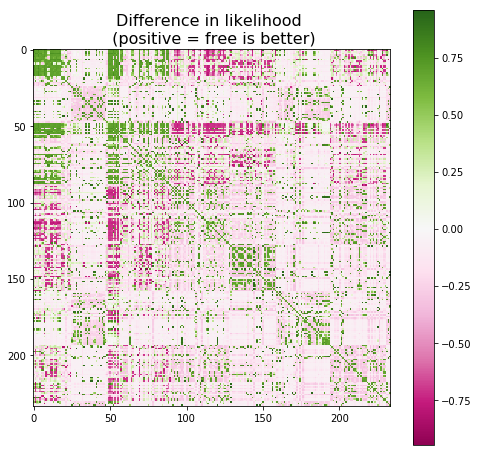

In [56]:
plt.figure(figsize=(8,8))
plt.title('Difference in likelihood \n (positive = free is better)', size=16)
plt.imshow((A_lh_fitted_freeR.exp()-A_lh_fitted.exp())[order,:][:,order], cmap='PiYG')
plt.colorbar()
plt.show()

# Fixed R

In [84]:
def tri(a):
    m = a.max()+10
    aa=(torch.ones(a.size()).triu(diagonal=1)*a + torch.ones(a.size()).triu(diagonal=0).t()*m).flatten()
    return aa[aa!=m]

In [ ]:
def tri_ord(a, core, index)

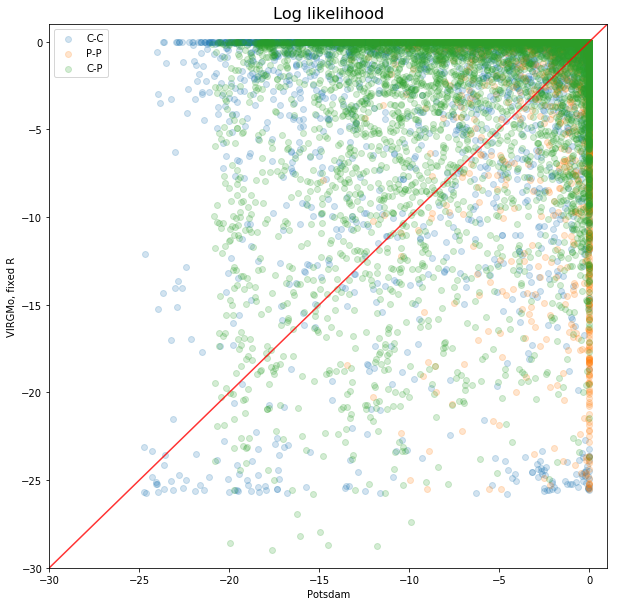

In [143]:
core = 90
alpha = 0.2
plt.figure(figsize=(10,10))
plt.title('Log likelihood', size=16)
plt.scatter(tri(A_lh_Potsdam[order,:][:,order][:core,:core]), 
            tri(A_lh_fitted[order,:][:,order][:core,:core]), alpha=alpha, label='C-C')
plt.scatter(tri(A_lh_Potsdam[order,:][:,order][core:,core:]), 
            tri(A_lh_fitted[order,:][:,order][core:,core:]), alpha=alpha, label='P-P')
plt.scatter(A_lh_Potsdam[order,:][:,order][:core,core:], 
            A_lh_fitted[order,:][:,order][:core,core:], alpha=alpha, label='C-P')
plt.xlabel('Potsdam')
plt.ylabel('VIRGMo, fixed R')
plt.legend()
plt.xlim(-30,1)
#plt.ylim(-4,1)
plt.ylim(-30,1)
x = torch.arange(-30,10,1)
plt.plot(x,x, 'r', alpha=0.8)
plt.show()

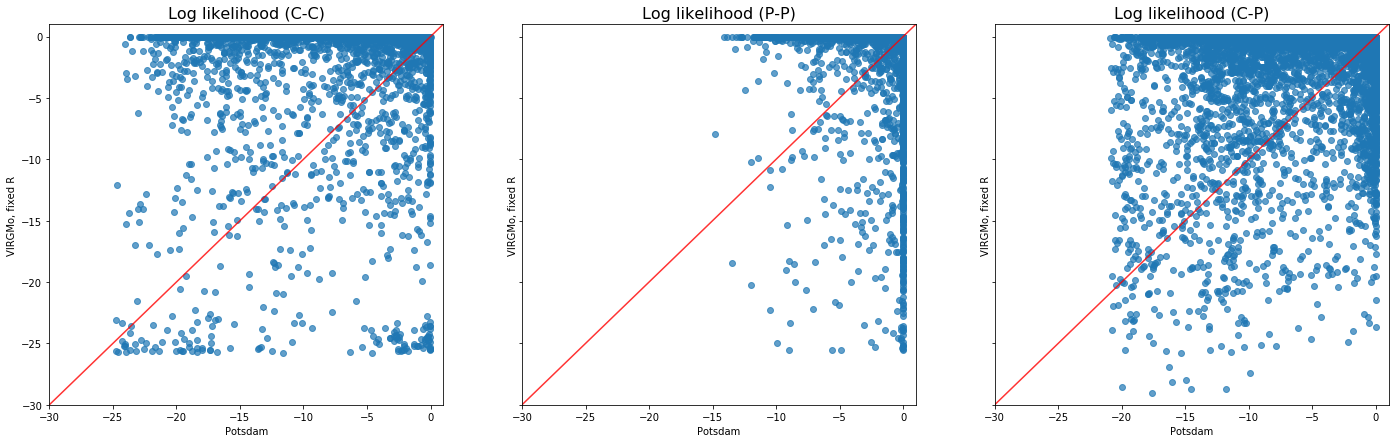

In [112]:
core = 90
alpha = 0.7
x = torch.arange(-30,10,1)
fig, axs = plt.subplots(1, 3, figsize=(24, 7), sharey=True)
labels = ['C-C', 'P-P', 'C-P']

axs[0].scatter(tri(A_lh_Potsdam[order,:][:,order][:core,:core]), 
            tri(A_lh_fitted[order,:][:,order][:core,:core]), alpha=alpha, label='C-C')
axs[1].scatter(tri(A_lh_Potsdam[order,:][:,order][core:,core:]), 
            tri(A_lh_fitted[order,:][:,order][core:,core:]), alpha=alpha, label='P-P')
axs[2].scatter(A_lh_Potsdam[order,:][:,order][:core,core:], 
            A_lh_fitted[order,:][:,order][:core,core:], alpha=alpha, label='C-P')
for i in range(3):
    axs[i].plot(x,x, 'r', alpha=0.8)
    axs[i].set_title('Log likelihood (%s)' % labels[i], size=16)
    axs[i].set_xlabel('Potsdam')
    axs[i].set_ylabel('VIRGMo, fixed R')
    axs[i].set_xlim(-30,1)
    axs[i].set_ylim(-30,1)
#plt.legend()



plt.show()

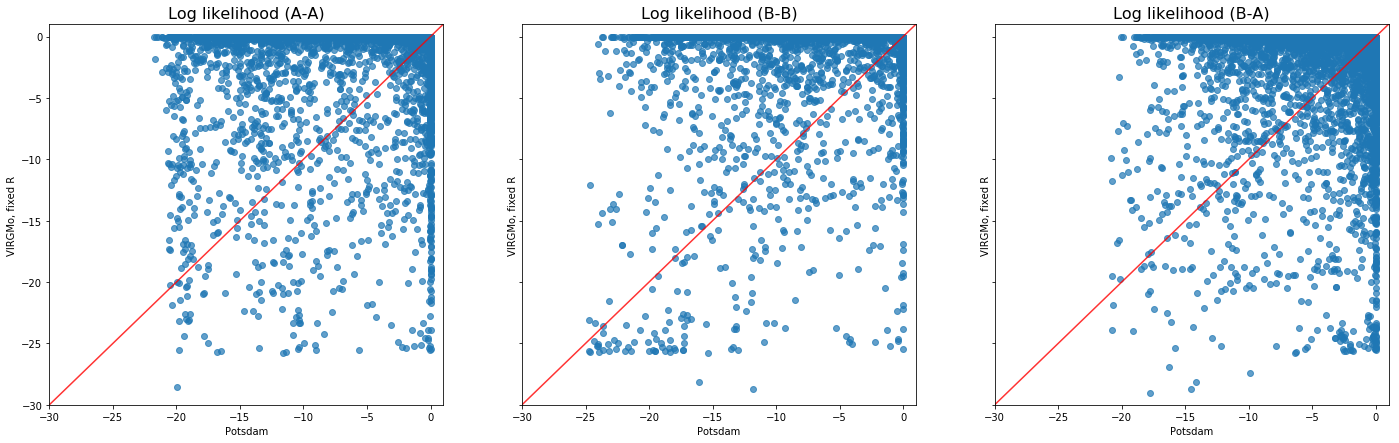

In [140]:
core = 90
alpha = 0.7
x = torch.arange(-30,10,1)
fig, axs = plt.subplots(1, 3, figsize=(24, 7), sharey=True)
labels = ['A-A', 'B-B', 'B-A']

axs[0].scatter(tri(A_lh_Potsdam[assets_num,:][:,assets_num]), 
            tri(A_lh_fitted[assets_num,:][:,assets_num]), alpha=alpha, label='C-C')
axs[1].scatter(tri(A_lh_Potsdam[banks_num,:][:,banks_num]), 
            tri(A_lh_fitted[banks_num,:][:,banks_num]), alpha=alpha, label='P-P')
axs[2].scatter(A_lh_Potsdam[banks_num,:][:,assets_num].flatten(), 
            A_lh_fitted[banks_num,:][:,assets_num].flatten(), alpha=alpha, label='C-P')
for i in range(3):
    axs[i].plot(x,x, 'r', alpha=0.8)
    axs[i].set_title('Log likelihood (%s)' % labels[i], size=16)
    axs[i].set_xlabel('Potsdam')
    axs[i].set_ylabel('VIRGMo, fixed R')
    axs[i].set_xlim(-30,1)
    axs[i].set_ylim(-30,1)
plt.show()

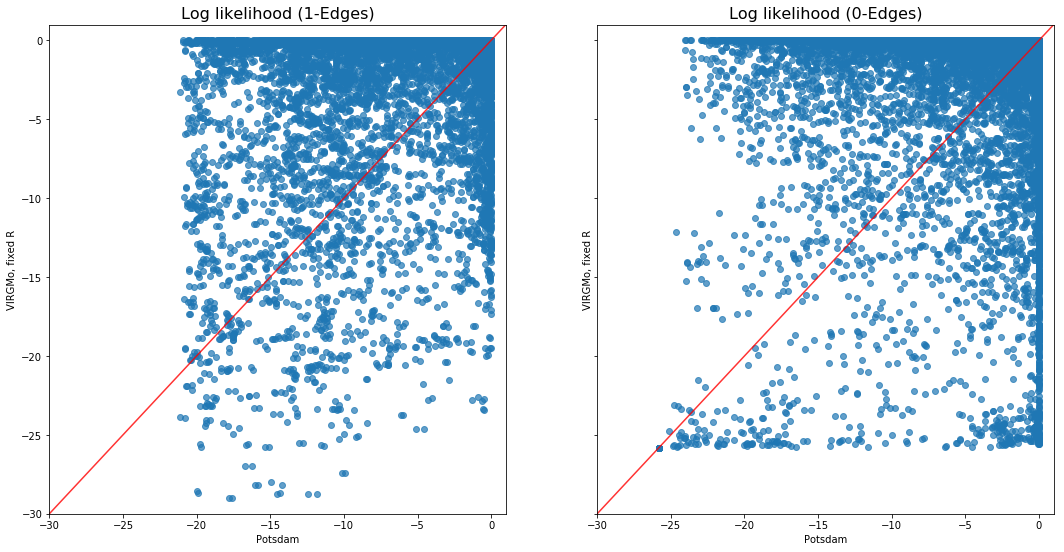

In [141]:
core = 90
alpha = 0.7
x = torch.arange(-30,10,1)
fig, axs = plt.subplots(1, 2, figsize=(18, 9), sharey=True)
labels = ['1-Edges', '0-Edges']

axs[0].scatter(A_lh_Potsdam[A_pi_edges==1], A_lh_fitted[A_pi_edges==1], alpha=alpha)
axs[1].scatter(A_lh_Potsdam[A_pi_edges==0], A_lh_fitted[A_pi_edges==0], alpha=alpha)

for i in range(2):
    axs[i].plot(x,x, 'r', alpha=0.8)
    axs[i].set_title('Log likelihood (%s)' % labels[i], size=16)
    axs[i].set_xlabel('Potsdam')
    axs[i].set_ylabel('VIRGMo, fixed R')
    axs[i].set_xlim(-30,1)
    axs[i].set_ylim(-30,1)
plt.show()

# Free R

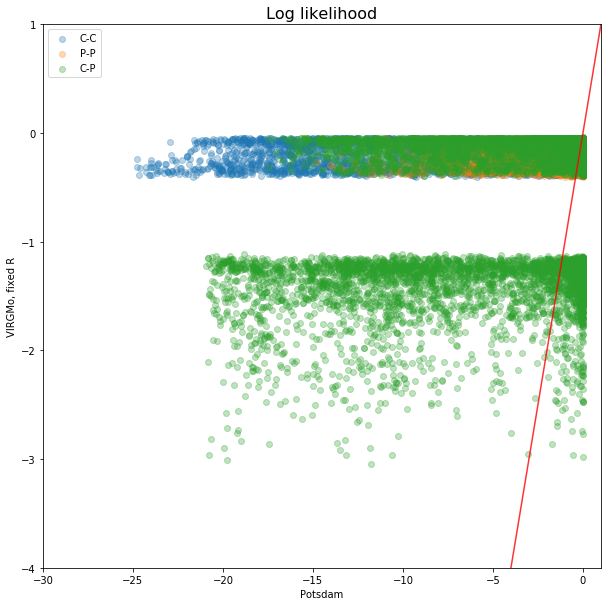

In [114]:
core = 90
alpha = 0.3
plt.figure(figsize=(10,10))
plt.title('Log likelihood', size=16)
plt.scatter(tri(A_lh_Potsdam[order,:][:,order][:core,:core]), 
            tri(A_lh_fitted_freeR[order,:][:,order][:core,:core]), alpha=alpha, label='C-C')
plt.scatter(tri(A_lh_Potsdam[order,:][:,order][core:,core:]), 
            tri(A_lh_fitted_freeR[order,:][:,order][core:,core:]), alpha=alpha, label='P-P')
plt.scatter(A_lh_Potsdam[order,:][:,order][:core,core:], 
            A_lh_fitted_freeR[order,:][:,order][:core,core:], alpha=alpha, label='C-P')
plt.xlabel('Potsdam')
plt.ylabel('VIRGMo, fixed R')
plt.legend()
plt.xlim(-30,1)
plt.ylim(-4,1)
#plt.ylim(-30,1)
x = torch.arange(-30,10,1)
plt.plot(x,x, 'r', alpha=0.8)
plt.show()

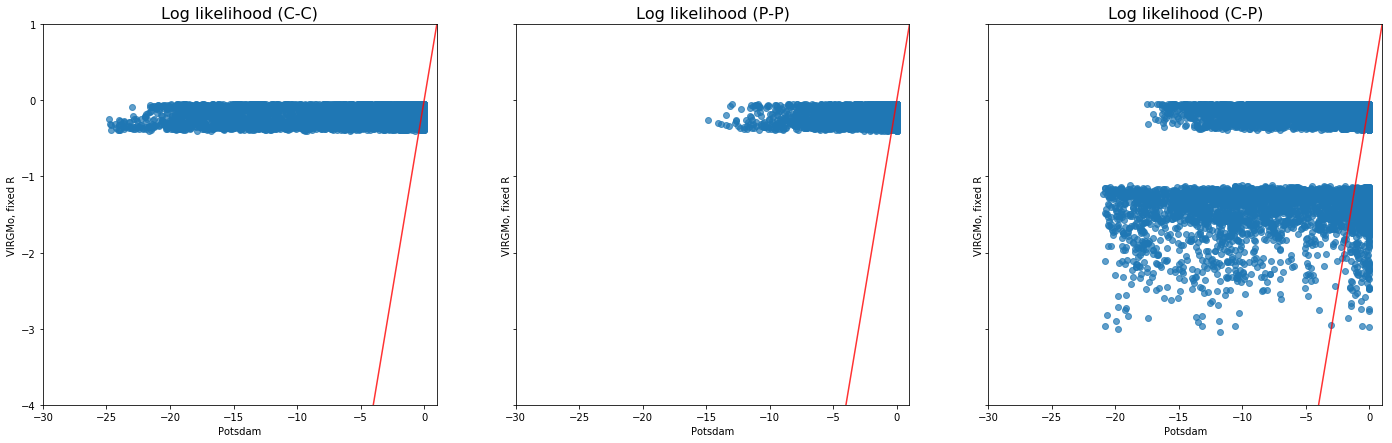

In [126]:
core = 90
alpha = 0.7
x = torch.arange(-30,10,1)
fig, axs = plt.subplots(1, 3, figsize=(24, 7), sharey=True)
labels = ['C-C', 'P-P', 'C-P']

axs[0].scatter(tri(A_lh_Potsdam[order,:][:,order][:core,:core]), 
            tri(A_lh_fitted_freeR[order,:][:,order][:core,:core]), alpha=alpha, label='C-C')
axs[1].scatter(tri(A_lh_Potsdam[order,:][:,order][core:,core:]), 
            tri(A_lh_fitted_freeR[order,:][:,order][core:,core:]), alpha=alpha, label='P-P')
axs[2].scatter(A_lh_Potsdam[order,:][:,order][:core,core:], 
            A_lh_fitted_freeR[order,:][:,order][:core,core:], alpha=alpha, label='C-P')
for i in range(3):
    axs[i].plot(x,x, 'r', alpha=0.8)
    axs[i].set_title('Log likelihood (%s)' % labels[i], size=16)
    axs[i].set_xlabel('Potsdam')
    axs[i].set_ylabel('VIRGMo, fixed R')
    axs[i].set_xlim(-30,1)
    axs[i].set_ylim(-4,1)
plt.show()

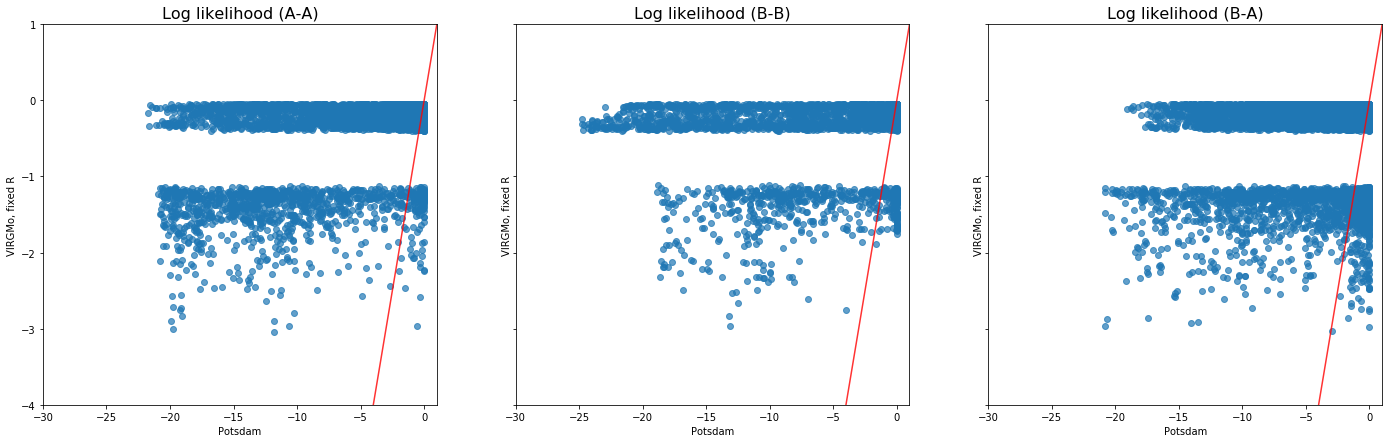

In [133]:
core = 90
alpha = 0.7
x = torch.arange(-30,10,1)
fig, axs = plt.subplots(1, 3, figsize=(24, 7), sharey=True)
labels = ['A-A', 'B-B', 'B-A']

axs[0].scatter(tri(A_lh_Potsdam[assets_num,:][:,assets_num]), 
            tri(A_lh_fitted_freeR[assets_num,:][:,assets_num]), alpha=alpha, label='C-C')
axs[1].scatter(tri(A_lh_Potsdam[banks_num,:][:,banks_num]), 
            tri(A_lh_fitted_freeR[banks_num,:][:,banks_num]), alpha=alpha, label='P-P')
axs[2].scatter(A_lh_Potsdam[banks_num,:][:,assets_num].flatten(), 
            A_lh_fitted_freeR[banks_num,:][:,assets_num].flatten(), alpha=alpha, label='C-P')
for i in range(3):
    axs[i].plot(x,x, 'r', alpha=0.8)
    axs[i].set_title('Log likelihood (%s)' % labels[i], size=16)
    axs[i].set_xlabel('Potsdam')
    axs[i].set_ylabel('VIRGMo, fixed R')
    axs[i].set_xlim(-30,1)
    axs[i].set_ylim(-4,1)
plt.show()

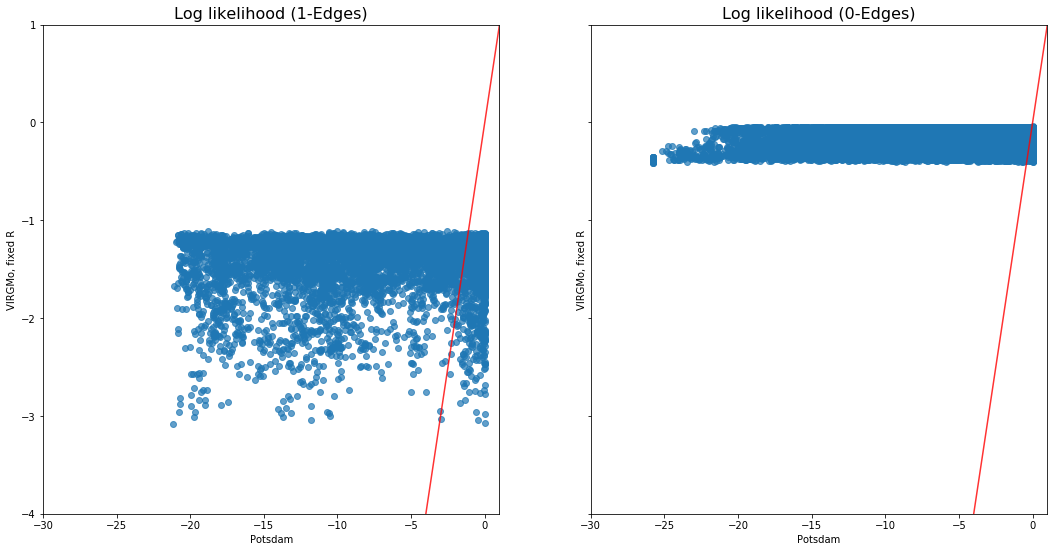

In [138]:
core = 90
alpha = 0.7
x = torch.arange(-30,10,1)
fig, axs = plt.subplots(1, 2, figsize=(18, 9), sharey=True)
labels = ['1-Edges', '0-Edges']

axs[0].scatter(A_lh_Potsdam[A_pi_edges==1], A_lh_fitted_freeR[A_pi_edges==1], alpha=alpha)
axs[1].scatter(A_lh_Potsdam[A_pi_edges==0], A_lh_fitted_freeR[A_pi_edges==0], alpha=alpha)

for i in range(2):
    axs[i].plot(x,x, 'r', alpha=0.8)
    axs[i].set_title('Log likelihood (%s)' % labels[i], size=16)
    axs[i].set_xlabel('Potsdam')
    axs[i].set_ylabel('VIRGMo, fixed R')
    axs[i].set_xlim(-30,1)
    axs[i].set_ylim(-4,1)
plt.show()

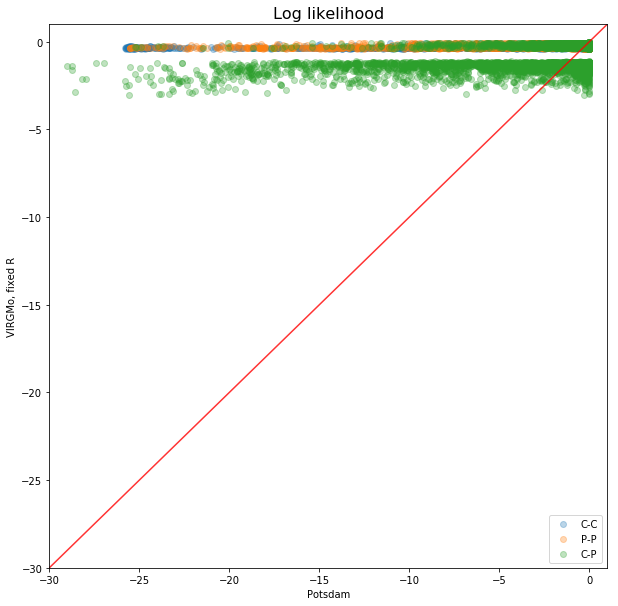

In [148]:
core = 90
alpha = 0.3
plt.figure(figsize=(10,10))
plt.title('Log likelihood', size=16)
plt.scatter(tri(A_lh_fitted[order,:][:,order][:core,:core]), 
            tri(A_lh_fitted_freeR[order,:][:,order][:core,:core]), alpha=alpha, label='C-C')
plt.scatter(tri(A_lh_fitted[order,:][:,order][core:,core:]), 
            tri(A_lh_fitted_freeR[order,:][:,order][core:,core:]), alpha=alpha, label='P-P')
plt.scatter(A_lh_fitted[order,:][:,order][:core,core:], 
            A_lh_fitted_freeR[order,:][:,order][:core,core:], alpha=alpha, label='C-P')
plt.xlabel('Potsdam')
plt.ylabel('VIRGMo, fixed R')
plt.legend()
plt.xlim(-30,1)
#plt.ylim(-4,1)
plt.ylim(-30,1)
x = torch.arange(-30,10,1)
plt.plot(x,x, 'r', alpha=0.8)
plt.show()